# Using SageMaker Processing for pre-processing, prediction and post-processing with TensorFlow

#### LEARN MORE [HERE](https://docs.aws.amazon.com/sagemaker/latest/dg/processing-job.html)

![image.png](https://docs.aws.amazon.com/sagemaker/latest/dg/images/Processing-1.png)

To analyze data and evaluate machine learning models on Amazon SageMaker, use Amazon SageMaker Processing. With Processing, you can use a simplified, managed experience on SageMaker to run your data processing workloads, such as feature engineering, data validation, model evaluation, and model interpretation. You can also use the Amazon SageMaker Processing APIs during the experimentation phase and after the code is deployed in production to evaluate performance.
        
The preceding diagram shows how Amazon SageMaker spins up a Processing job. Amazon SageMaker takes your script, copies your data from Amazon Simple Storage Service (Amazon S3), and then pulls a processing container. The processing container image can either be an Amazon SageMaker built-in image or a custom image that you provide. The underlying infrastructure for a Processing job is fully managed by Amazon SageMaker. Cluster resources are provisioned for the duration of your job, and cleaned up when a job completes. The output of the Processing job is stored in the Amazon S3 bucket you specified.


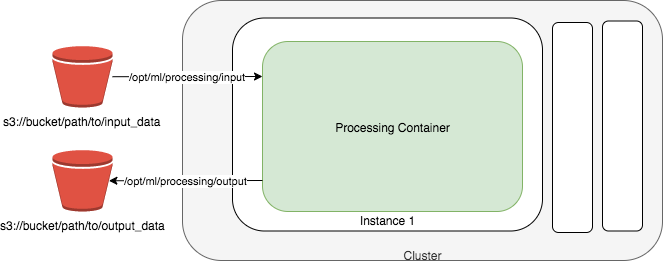

In [ ]:
!pip install -qU sagemaker
!mkdir -p .data .output

#### NOTE: restart the kernel after executing the above cell!

## Step 0 - Creating the `model.tar.gz` (unless already done via SM Training or other)

In [ ]:
import tensorflow.keras as keras
import numpy as np
import tarfile 

def get_model():
    # Create a simple model.
    inputs = keras.Input(shape=(32,))
    outputs = keras.layers.Dense(1)(inputs)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="mean_squared_error")
    return model


model = get_model()

# Train the model.
test_input = np.random.random((128, 32))
test_target = np.random.random((128, 1))
model.fit(test_input, test_target)
    
# Save a new dataset for later
np.save('.data/data.npy', np.random.random((128, 32)))

# Calling `save('my_model')` creates a SavedModel folder `my_model`.
model.save(".output/my_model")

# Create the model.tar.gz 
with tarfile.open('model.tar.gz', 'w:gz') as w:
    w.add('.output/my_model/assets/', 'assets/')
    w.add('.output/my_model/variables/', 'variables/')
    w.add('.output/my_model/saved_model.pb', 'saved_model.pb')

Test that the load logic works:

In [ ]:
from tensorflow.keras.models import load_model

model = load_model(".output/my_model")

Now upload the file to S3:

In [ ]:
from sagemaker import Session

session = Session()

data_path = session.upload_data('.data', session.default_bucket(), 'tensorflow-processing-example/data')
print(f'Data uploaded at {data_path}')
model_path = session.upload_data('model.tar.gz', session.default_bucket(), 'tensorflow-processing-example/model')
print(f'Model uploaded at {model_path}')

## Step 1 - Create the script you'd like to use with Processing with your logic

This script is executed by Amazon SageMaker.

In the `main`, it does the core of the operations: it reads and parses arguments passed as parameters, unpacks the model file, then loads the model, preprocess, predict, postprocess the data. Remember to write data locally in the final step so that SageMaker can copy them to S3.

In [ ]:
!pygmentize inference_with_processing.py

## Step 2 - Launch the Processing Job

Once the script is written, create the SM Processing Job. 

In [ ]:
from sagemaker.tensorflow import TensorFlowProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker import get_execution_role, Session

session = Session()

BUCKET = input('The bucket you want to use:') or session.default_bucket()
S3_PATH_TO_MODEL = input('The S3 path to the model.tar.gz:') or 'tensorflow-processing-example/model/'
S3_PATH_TO_DATA = input('The S3 path to the dataset:') or 'tensorflow-processing-example/data/'
S3_OUTPUT_PATH = input('The S3 path where to store the output:') or 'tensorflow-processing-example/output/'


# Instantiate the TensorFlowProcessor object
tp = TensorFlowProcessor(
    framework_version='2.3',
    role = get_execution_role(),
    instance_count=1,
    instance_type='ml.m5.large',
    base_job_name='frameworkprocessor-TF',
    py_version='py37'
)
# Run it
tp.run(
    code = 'inference_with_processing.py',
    inputs=[
        ProcessingInput(
            input_name='data',
            source=f's3://{BUCKET}/{S3_PATH_TO_DATA}',
            destination='/opt/ml/processing/input/data'
        ),
        ProcessingInput(
            input_name='model',
            source=f's3://{BUCKET}/{S3_PATH_TO_MODEL}',
            destination='/opt/ml/processing/input/model'
        )
    ],
    outputs=[
        ProcessingOutput(
            output_name='predictions',
            source='/opt/ml/processing/output',
            destination=f's3://{BUCKET}/{S3_OUTPUT_PATH}'
        )
    ]
)